# Tuto transfert de style neuronal

Tuto à voir ici hihi : https://www.tensorflow.org/tutorials/generative/style_transfer

Le transfert de style neuronal est une technique d'optimisation utilisée pour prendre deux images - une image de contenu et une image de référence de style (comme une illustration d'un peintre célèbre) - et les mélanger afin que l'image de sortie ressemble à l'image de contenu, mais «peinte». dans le style de l'image de référence de style.

Ceci est mis en œuvre en optimisant l'image de sortie pour qu'elle corresponde aux statistiques de contenu de l'image de contenu et aux statistiques de style de l'image de référence de style. Ces statistiques sont extraites des images à l'aide d'un réseau convolutif.

In [1]:
import numpy as np
import PIL.Image
import time
import functools
import os
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
import tensorflow as tf
import tensorflow_hub as hub
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

In [2]:
# Conversion d'un tenseur en image
def tensor_to_image(tensor):
    tensor = np.array(tensor * 255, dtype = np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

Téléchargez des images et choisissez une image de style et une image de contenu:

In [3]:
# Import de l'image d'entrée + style
content_path = tf.keras.utils.get_file('carla.jpg', 'https://resize.programme-television.ladmedia.fr/r/670,670/img/var/premiere/storage/images/tele-7-jours/news-tv/carla-moreau-les-marseillais-apres-l-affaire-de-sorcellerie-elle-repond-a-une-nouvelle-polemique-4670722/99427758-1-fre-FR/Carla-Moreau-Les-Marseillais-Apres-l-affaire-de-sorcellerie-elle-repond-a-une-nouvelle-polemique.jpg')
style_path = tf.keras.utils.get_file('vangogh.jpg','https://www.kazoart.com/blog/wp-content/uploads/2017/03/van-gogh-la-nuit-etoilee-1.jpg')

## Visualisez l'entrée
Définissez une fonction pour charger une image et limiter sa dimension maximale à 512 pixels.



In [4]:
# Chargement d'une image et limitation de sa dimension maximale à 512 pixels
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

Créez une fonction simple pour afficher une image:

In [5]:
# Afficher une image
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

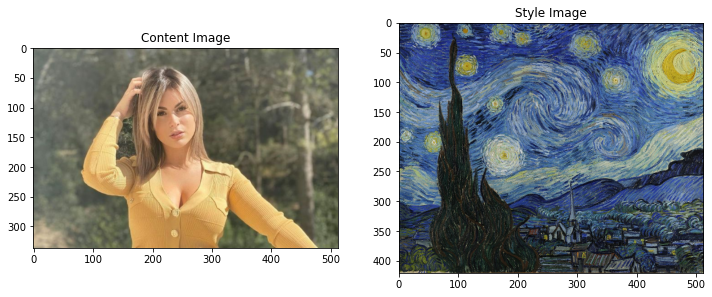

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

### Transfert de style rapide à l'aide de TF-Hub Modèle utilisé
Algorithme de transfert de style d'origine, qui optimise le contenu de l'image selon un style particulier. Avant d'entrer dans les détails, voyons comment le modèle TensorFlow Hub fait cela: https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2

In [7]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

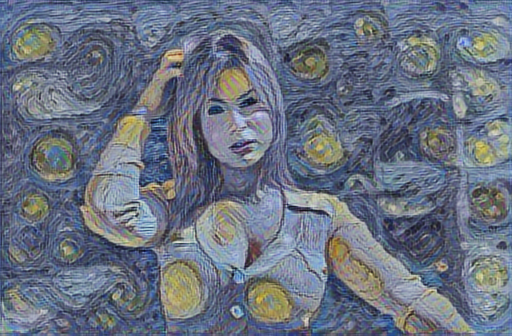

In [8]:
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Définir le contenu et les représentations de style

On va utiliser les couches intermédiaires du réseau de neurones pour obtenir le contenu et les représentations de style.

### Comment ça marche ?
A partir de la 1ère couche du réseau (couche d'entrée) : les premières activations de couche représentent des entités de "bas niveau" genre bords / textures de l'image.
Plus on va loin dans le réseau : plus on va dans les "niveaux supérieurs" qui représentent des parties d'objets comme des roues, des yeux ...

VGG19 est un réseau de classification d'images pré-entrainé. On va l'utiliser pour accéder aux couches intermédiaires.

In [9]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [10]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('cloak', 0.116109006),
 ('miniskirt', 0.093457304),
 ('maillot', 0.08876542),
 ('bikini', 0.07633759),
 ('maillot', 0.07450913)]

On charge un `VGG19` sans la tête de classification et avec ses couches

In [11]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


On choisit les couches intermédiaires du réseau pour représenter le style et le contenu de l'image:

In [12]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Couches intermédiaires pour le style et le contenu
Pourquoi les sorties intermédiaires au sein de notre réseau de classification d'images pré-entraîné nous permettent-elles de définir des représentations de style et de contenu?

À un niveau élevé, pour qu'un réseau puisse effectuer une classification d'image (ce à quoi ce réseau a été formé), il doit comprendre l'image. Cela nécessite de prendre l'image brute comme pixels d'entrée et de construire une représentation interne qui convertit les pixels d'image brute en une compréhension complexe des caractéristiques présentes dans l'image.

C'est aussi une raison pour laquelle les réseaux de neurones convolutifs sont capables de bien généraliser: ils sont capables de capturer les invariances et les caractéristiques de définition au sein des classes (par exemple, les chats contre les chiens) qui sont agnostiques au bruit de fond et à d'autres nuisances. Ainsi, quelque part entre l'endroit où l'image brute est introduite dans le modèle et l'étiquette de classification de sortie, le modèle sert d'extraction de caractéristiques complexes. En accédant aux couches intermédiaires du modèle, vous pouvez décrire le contenu et le style des images d'entrée.

## Construisons le modèle
Les réseaux dans `tf.keras.applications` sont conçus pour qu'on puisse facilement extraire les valeurs de couche intermédiaire à l'aide de l'API fonctionnelle Keras.

Pour définir un modèle à l'aide de l'API fonctionnelle, on spécifie les entrées et les sorties:

`model = Model(inputs, outputs)`

La fonction suivante crée un modèle VGG19 qui renvoie une liste de sorties de couche intermédiaire:

In [13]:
def vgg_layers(layer_names):
    """ Créé un modèle VGG qui retourne une liste de valeurs de sorties intermédiaires."""
    # Chargement de notre modèle. On charge un VGG préentraîné sur les données imagenet
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

On créé le modèle :

In [14]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 421, 512, 64)
  min:  0.0
  max:  671.8131
  mean:  23.640066

block2_conv1
  shape:  (1, 210, 256, 128)
  min:  0.0
  max:  2860.4924
  mean:  146.5855

block3_conv1
  shape:  (1, 105, 128, 256)
  min:  0.0
  max:  6279.1187
  mean:  141.1391

block4_conv1
  shape:  (1, 52, 64, 512)
  min:  0.0
  max:  13860.016
  mean:  550.6428

block5_conv1
  shape:  (1, 26, 32, 512)
  min:  0.0
  max:  4071.5588
  mean:  47.88345



## Calculons le style

Le contenu d'une image est représenté par les valeurs des cartes de caractéristiques intermédiaires.

Il s'avère que le style d'une image peut être décrit par les moyens et les corrélations entre les différentes cartes de caractéristiques. Calculons une matrice de Gram qui inclut ces informations en prenant le produit externe du vecteur de caractéristiques avec lui-même à chaque emplacement et en faisant la moyenne de ce produit externe sur tous les emplacements. Cette matrice de Gram peut être calculée pour une couche particulière comme suit:

$$G_{cd}^l=\frac{\sum_{ij}F_{ijc}^l(x)F_{ijd}^l(x)}{IJ}$$

Cela peut être implémenté de manière concise en utilisant la fonction `tf.linalg.einsum` :

In [15]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

## Extraction du style et du contenu

Créons un modèle qui renvoie les tenseurs de style et de contenu.

In [16]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Requis : entrée float dans [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

        content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

Lorsqu'il est appelé sur une image, ce modèle renvoie la matrice de gramme (style) des `style_layers` et le contenu des `content_layers` :

In [17]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0021899596
    max:  11265.418
    mean:  184.39673

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  32269.84
    mean:  5919.053

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.020838495
    max:  121668.3
    mean:  6790.066

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  1072251.6
    mean:  97664.625

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  81312.73
    mean:  1108.2881

Contents:
   block5_conv2
    shape:  (1, 21, 32, 512)
    min:  0.0
    max:  1319.7062
    mean:  12.191725
